# infoGAN with MNIST

* MNIST data를 가지고 **infoGAN**를 `tf.contrib.slim`을 이용하여 만들어보자.
  * [참고: TensorFlow slim](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim)
* based on dcgan

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf

slim = tf.contrib.slim
tf.logging.set_verbosity(tf.logging.INFO)

tf.set_random_seed(219)
np.random.seed(219)

os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/lab4all/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/lab4all/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
FLAGS = tf.app.flags.FLAGS

# Training Flags
tf.app.flags.DEFINE_string('train_dir', 'train/infogan/exp1', '')
tf.app.flags.DEFINE_integer('max_epochs', 100, '')
tf.app.flags.DEFINE_integer('save_epochs', 10, '')
tf.app.flags.DEFINE_integer('summary_steps', 5000, '')
tf.app.flags.DEFINE_integer('print_steps', 2000, '')
tf.app.flags.DEFINE_integer('batch_size', 64, '')
tf.app.flags.DEFINE_float('learning_rate_D', 0.0002, '')
tf.app.flags.DEFINE_float('learning_rate_G', 0.001, '')
tf.app.flags.DEFINE_integer('k', 1, 'the number of step of learing D before learning G')
tf.app.flags.DEFINE_integer('num_samples', 10, '')

## Import MNIST

In [3]:
data_dir = 'mnist'
mnist = input_data.read_data_sets(data_dir, one_hot=True)
num_examples = len(mnist.train.images)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


## Create the model

In [4]:
class InfoGAN_model(object):
  """InfoGAN 
  implementation based on http://arxiv.org/abs/1606.03657
  
  "InfoGAN: Interpretable Representation Learning by
  Information Maximizing Generative Adversarial Nets"
  Xi Chen, Yan Duan, Rein Houthooft, John Schulman,
  Ilya Sutskever, Pieter Abbeel
  """
  
  def __init__(self, mode):
    """Basic setup.
    
    Args:
      mode: "train" or "generate"
    """
    assert mode in ["train", "generate"]
    self.mode = mode
    
    # hyper-parameters for model
    self.x_dim = 784
    self.z_dim = 62
    self.categorical_code_dim = 10 # for MNIST
    self.continuous_code_dim = 2
    self.batch_size = FLAGS.batch_size
    
    # Global step Tensor.
    self.global_step = None
    
    print('The mode is %s.' % self.mode)
    print('complete initializing model.')
    
    
  def build_inputs(self):
    """Build random_z + condition
    
    Returns:
      A float32 Tensor with [batch_size, z_dim]
    """
    # Setup variable of random vector z
    with tf.variable_scope('random_z'):
      self.random_z = tf.placeholder(tf.float32, [None, self.z_dim])
      
    # Setup placeholder of categorical_code
    with tf.variable_scope('categorical_code'):
      self.categorical_code = tf.placeholder(tf.float32, [None, self.categorical_code_dim])
      
    # Setup placeholder of continuous code
    with tf.variable_scope('continuous_code'):
      self.continuous_code = tf.placeholder(tf.float32, [None, self.continuous_code_dim])

    return self.random_z, self.categorical_code, self.continuous_code
  
  
  def read_MNIST(self):
    # Setup placeholder of real data (MNIST)
    with tf.variable_scope('mnist'):
      self.mnist = tf.placeholder(tf.float32, [None, self.x_dim])
      self.mnist_image = tf.reshape(self.mnist, [-1, 28, 28, 1])
      
      return self.mnist_image


  def Generator(self, random_z, categorical_code, continuous_code, is_training=True, reuse=False):
    """Generator setup.
    
    Args:
      random_z: A float32 Tensor random vector [batch_size, z_dim] (latent code)
      categorical_code: A float32 Tensor random vector [batch_size, categorical_code_dim] (categorical code)
      continuous_code: A float32 Tensor random vector [batch_size, continuous_code_dim] (continuous code)
      is_training: boolean whether training mode or generating mode
      reuse: variables reuse flag
      
    Returns:
      A float32 scalar Tensor of generated images from random vector
    """
    with tf.variable_scope('Generator') as scope:
      if reuse:
        scope.reuse_variables()
        
      batch_norm_params = {'decay': 0.9,
                           'epsilon': 0.00001,
                           'is_training': is_training,
                           'scope': 'batch_norm'}
      
      with slim.arg_scope([slim.fully_connected],
                          normalizer_fn=slim.batch_norm,
                          normalizer_params=batch_norm_params):
        # random_z: 62 dim
        # categorical code: 10 dim
        # continuous code: 2 dim
        # inputs: 62 + 10 + 2 = 74 dim
        self.inputs = tf.concat([random_z, categorical_code, continuous_code], axis=1)
        self.layer1 = slim.fully_connected(inputs=self.inputs,
                                           num_outputs=1024,
                                           scope='layer1')
        # layer1: 1024 dim
        self.layer2 = slim.fully_connected(inputs=self.layer1,
                                           num_outputs=7 * 7 * 128,
                                           scope='layer2')
        self.layer2_reshape = tf.reshape(self.layer2, [-1, 7, 7, 128])

      with slim.arg_scope([slim.conv2d_transpose],
                          kernel_size=[4, 4],
                          stride=[2, 2],
                          normalizer_fn=slim.batch_norm,
                          normalizer_params=batch_norm_params):
        # layer2: 7 x 7 x 128 dim
        self.layer3 = slim.conv2d_transpose(inputs=self.layer2_reshape,
                                            num_outputs=64,
                                            scope='layer3')
        # layer3: 14 x 14 x 64 dim
        self.layer4 = slim.conv2d_transpose(inputs=self.layer3,
                                            num_outputs=1,
                                            normalizer_fn=None,
                                            activation_fn=tf.sigmoid,
                                            scope='layer4')
        # output = layer4: 28 x 28 x 1 dim
        generated_data = self.layer4

        return generated_data
    
    
  def Discriminator(self, data, reuse=False):
    """Discriminator setup.
    
    Args:
      data: A float32 scalar Tensor of real data
      reuse: variables reuse flag
      
    Returns:
      logits: A float32 scalar Tensor
    """
    with tf.variable_scope('Discriminator') as scope:
      if reuse:
        scope.reuse_variables()
        
      batch_norm_params = {'decay': 0.9,
                           'epsilon': 0.00001,
                           'scope': 'batch_norm'}
      with slim.arg_scope([slim.conv2d],
                          kernel_size=[4, 4],
                          stride=[2, 2],
                          activation_fn=tf.nn.leaky_relu,
                          normalizer_fn=slim.batch_norm,
                          normalizer_params=batch_norm_params):

        # inputs: 28 x 28 x 1 dim
        self.layer1 = slim.conv2d(inputs=data,
                                  num_outputs=64,
                                  scope='layer1')
        # layer1: 14 x 14 x 64 dim
        self.layer2 = slim.conv2d(inputs=self.layer1,
                                  num_outputs=128,
                                  scope='layer2')
        self.layer2_flat = slim.flatten(self.layer2, scope='layer2_flat')
        
      with slim.arg_scope([slim.fully_connected],
                          normalizer_fn=slim.batch_norm,
                          normalizer_params=batch_norm_params):
        # layer2: (7 x 7 x 128) dim
        self.layer3 = slim.fully_connected(inputs=self.layer2_flat,
                                           num_outputs=1024,
                                           scope='layer3')
        # layer3: 1024 dim
        self.layer4 = slim.fully_connected(inputs=self.layer3,
                                           num_outputs=1,
                                           normalizer_fn=None,
                                           activation_fn=None,
                                           scope='logits')
        # logits = layer4: 1 dim
        discriminator_logits = self.layer4

        return discriminator_logits, self.layer3
      
      
  def Recognition_network(self, inputs):
    """Recognition network Q
      Read arXiv:1606.03657 for details
    """
    with tf.variable_scope('Recognition_network') as scope:
      
      batch_norm_params = {'decay': 0.9,
                           'epsilon': 0.00001,
                           'scope': 'batch_norm'}
      with slim.arg_scope([slim.fully_connected],
                          activation_fn=tf.nn.leaky_relu,
                          normalizer_fn=slim.batch_norm,
                          normalizer_params=batch_norm_params):
        # inputs: 1024 dim
        self.layer1 = slim.fully_connected(inputs=inputs,
                                           num_outputs=64,
                                           scope='layer1')
        # inputs: 128 dim
        self.layer2 = slim.fully_connected(inputs=self.layer1,
                                           num_outputs=self.categorical_code_dim + self.continuous_code_dim,
                                           normalizer_fn=None,
                                           activation_fn=None,
                                           scope='logits')
        # logits: (10 + 2) dim
        Q_logits = self.layer2
        Q_softmax = tf.nn.softmax(Q_logits)
        return Q_logits, Q_softmax
      
  
    
  def setup_global_step(self):
    """Sets up the global step Tensor."""
    if self.mode == "train":
      self.global_step = tf.Variable(initial_value=0,
                                     name='global_step',
                                     trainable=False,
                                     collections=[tf.GraphKeys.GLOBAL_STEP,
                                                  tf.GraphKeys.GLOBAL_VARIABLES])
      
      print('complete setup global_step.')
      
      
  def GANLoss(self, logits, is_real=True, scope=None):
    """Computes standard GAN loss between `logits` and `labels`.
    
    Args:
      logits: A float32 Tensor of logits.
      is_real: boolean, Treu means `1` labeling, False means `0` labeling.
      
    Returns:
      A scalar Tensor representing the loss value.
    """
    if is_real:
      labels = tf.ones_like(logits)
    else:
      labels = tf.zeros_like(logits)

    loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=labels,
                                           logits=logits,
                                           scope=scope)

    return loss

      
  def build(self):
    """Creates all ops for training or generate."""
    self.setup_global_step()
    
    # generating random vector
    self.random_z, self.categorical_code, self.continuous_code = self.build_inputs()
    
    if self.mode == "generate":
      pass
    
    else:
      # generating random vector
      self.random_z, self.categorical_code, self.continuous_code = self.build_inputs()
      # generating images from Generator() via random vector z
      self.generated_data = self.Generator(self.random_z, self.categorical_code, self.continuous_code)
      
      # read dataset
      self.real_data = self.read_MNIST()
      
      
      # GAN Loss part
      # discriminating real data by Discriminator()
      self.real_logits, _ = self.Discriminator(self.real_data)
      # discriminating fake data (generated_images) by Discriminator()
      self.fake_logits, self.recog_inputs = self.Discriminator(self.generated_data, reuse=True)
      
      # losses of real with label "1"
      self.loss_real = self.GANLoss(logits=self.real_logits, is_real=True, scope='loss_D_real')
      # losses of fake with label "0"
      self.loss_fake = self.GANLoss(logits=self.fake_logits, is_real=False, scope='loss_D_fake')
      
      # losses of Discriminator
      with tf.variable_scope('loss_D'):
        self.loss_Discriminator = self.loss_real + self.loss_fake
      # losses of Generator with label "1" that used to fool the Discriminator
      self.loss_Generator = self.GANLoss(logits=self.fake_logits, is_real=True, scope='loss_G')
      
      
      # Mutual information part
      # Categorical code
      self.q_logits, self.q_softmax = self.Recognition_network(self.recog_inputs)
      self.loss_Q_cate = tf.losses.softmax_cross_entropy(onehot_labels=self.categorical_code,
                                                         logits=self.q_logits[:, :self.categorical_code_dim],
                                                         scope='loss_Q_cate')
      # Continuous code
      self.loss_Q_cont = tf.losses.mean_squared_error(labels=self.continuous_code,
                                                      predictions=self.q_softmax[:, self.categorical_code_dim:],
                                                      scope='loss_Q_cont')
      #self.loss_Q_cont = tf.reduce_mean(
      #                      tf.reduce_sum(
      #                          tf.square(self.continuous_code - self.q_softmax[:, self.categorical_code_dim:]), axis=1))
      
      # losses of Recognition network
      with tf.variable_scope('loss_Q'):
        self.loss_Q = self.loss_Q_cate + self.loss_Q_cont    
      
      
      # Separate variables for each function
      self.D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')
      self.G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
      self.Q_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
      
      
      # generating images for sample
      self.sample_data = self.Generator(self.random_z, self.categorical_code,
                                        self.continuous_code, is_training=False, reuse=True)
      
      # write summaries
      tf.summary.scalar('losses/loss_Discriminator', self.loss_Discriminator)
      tf.summary.scalar('losses/loss_Generator', self.loss_Generator)
      tf.summary.scalar('losses/loss_Recognition', self.loss_Q)

      # Add histogram summaries
      for var in self.D_vars:
        tf.summary.histogram(var.op.name, var)
      for var in self.G_vars:
        tf.summary.histogram(var.op.name, var)
        
      # Add image summaries
      tf.summary.image('random_images', tf.reshape(self.generated_data, [-1, 28, 28, 1]), max_outputs=4)
      #tf.summary.image('real_images', tf.reshape(self.real_data, [-1, 28, 28, 1]))
      
    print('complete model build.\n')

## Define plot function

In [5]:
def print_sample_data(sample_data1, sample_data2, max_print=10):
  images1 = sample_data1[:max_print,:]
  images1 = images1.reshape([max_print, 28, 28])
  images1 = images1.swapaxes(0, 1)
  images1 = images1.reshape([28, max_print * 28])
  
  images2 = sample_data2[:max_print,:]
  images2 = images2.reshape([max_print, 28, 28])
  images2 = images2.swapaxes(0, 1)
  images2 = images2.reshape([28, max_print * 28])
  
  print_images = np.concatenate((images1, images2), axis=0)  
   
  plt.figure(figsize=(max_print, 2))
  plt.axis('off')
  plt.imshow(print_images, cmap='gray')
  plt.show()

## Build a model

In [6]:
model = InfoGAN_model(mode="train")
model.build()

# show info for trainable variables
t_vars = tf.trainable_variables()
slim.model_analyzer.analyze_vars(t_vars, print_info=True)

The mode is train.
complete initializing model.
complete setup global_step.
complete model build.

---------
Variables: name (type shape) [size]
---------
Generator/layer1/weights:0 (float32_ref 74x1024) [75776, bytes: 303104]
Generator/layer1/batch_norm/beta:0 (float32_ref 1024) [1024, bytes: 4096]
Generator/layer2/weights:0 (float32_ref 1024x6272) [6422528, bytes: 25690112]
Generator/layer2/batch_norm/beta:0 (float32_ref 6272) [6272, bytes: 25088]
Generator/layer3/weights:0 (float32_ref 4x4x64x128) [131072, bytes: 524288]
Generator/layer3/batch_norm/beta:0 (float32_ref 64) [64, bytes: 256]
Generator/layer4/weights:0 (float32_ref 4x4x1x64) [1024, bytes: 4096]
Generator/layer4/biases:0 (float32_ref 1) [1, bytes: 4]
Discriminator/layer1/weights:0 (float32_ref 4x4x1x64) [1024, bytes: 4096]
Discriminator/layer1/batch_norm/beta:0 (float32_ref 64) [64, bytes: 256]
Discriminator/layer2/weights:0 (float32_ref 4x4x64x128) [131072, bytes: 524288]
Discriminator/layer2/batch_norm/beta:0 (float32_

(13261006, 53044024)

In [7]:
opt_D = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate_D, beta1=0.5)
opt_G = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate_G, beta1=0.5)
opt_Q = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate_G, beta1=0.5)

In [8]:
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Discriminator')):
  opt_D_op = opt_D.minimize(model.loss_Discriminator, var_list=model.D_vars)
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')):
  opt_G_op = opt_G.minimize(model.loss_Generator, global_step=model.global_step,
                            var_list=model.G_vars)
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
  opt_Q_op = opt_Q.minimize(model.loss_Q, var_list=model.Q_vars)

In [9]:
saver = tf.train.Saver(tf.global_variables(), max_to_keep=1000)

summary_op = tf.summary.merge_all()

sv = tf.train.Supervisor(logdir=FLAGS.train_dir,
                         summary_op=None,
                         saver=saver,
                         save_model_secs=0,
                         init_fn=None)

INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Start Session.
Epochs: 2.327 global_step: 2000  loss_D: 1.31949  loss_G: 0.788252  loss_Q: 0.257411 (2868.4 examples/sec; 0.022 sec/batch)


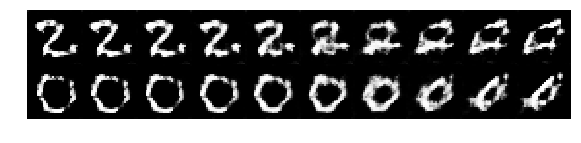

Epochs: 4.655 global_step: 4000  loss_D: 1.30026  loss_G: 0.798105  loss_Q: 0.158019 (2942.3 examples/sec; 0.022 sec/batch)


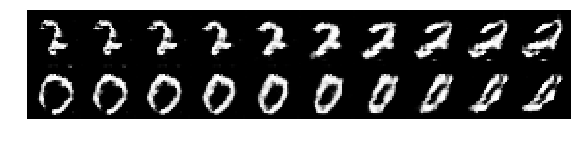

INFO:tensorflow:global_step/sec: 41.8333
Epochs: 6.983 global_step: 6000  loss_D: 1.31706  loss_G: 0.768237  loss_Q: 0.183075 (2880.7 examples/sec; 0.022 sec/batch)


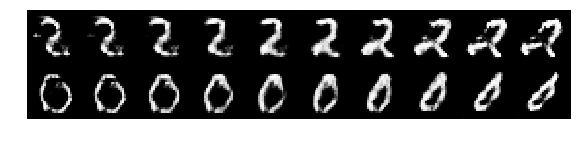

Epochs: 9.312 global_step: 8000  loss_D: 1.35401  loss_G: 0.742167  loss_Q: 0.182452 (3064.8 examples/sec; 0.021 sec/batch)


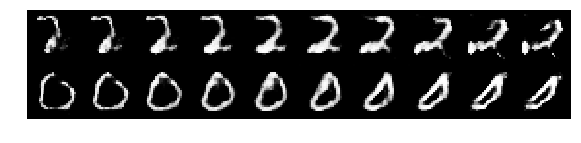

INFO:tensorflow:Saving model with global step 8591 (= 10 epochs) to disk.
Epochs: 11.640 global_step: 10000  loss_D: 1.32908  loss_G: 0.762261  loss_Q: 0.195805 (2888.5 examples/sec; 0.022 sec/batch)


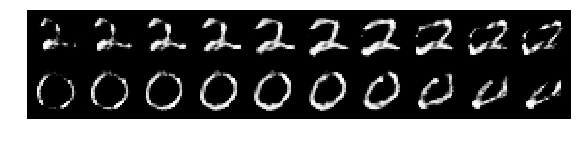

INFO:tensorflow:global_step/sec: 44.0916
Epochs: 13.968 global_step: 12000  loss_D: 1.3306  loss_G: 0.752579  loss_Q: 0.185255 (2881.7 examples/sec; 0.022 sec/batch)


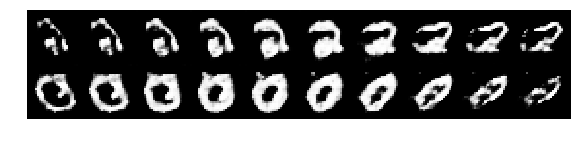

Epochs: 16.297 global_step: 14000  loss_D: 1.37832  loss_G: 0.738541  loss_Q: 0.219158 (3020.7 examples/sec; 0.021 sec/batch)


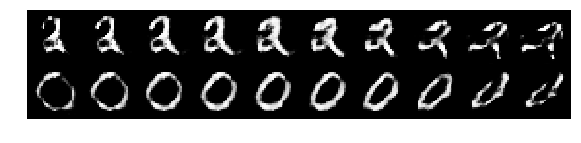

INFO:tensorflow:global_step/sec: 45.5751
Epochs: 18.625 global_step: 16000  loss_D: 1.31632  loss_G: 0.766945  loss_Q: 0.186692 (2979.6 examples/sec; 0.021 sec/batch)


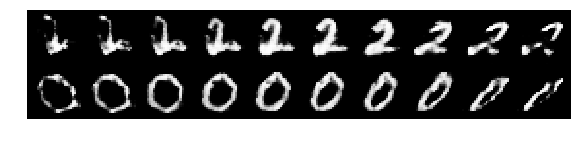

INFO:tensorflow:Saving model with global step 17181 (= 20 epochs) to disk.
Epochs: 20.953 global_step: 18000  loss_D: 1.37924  loss_G: 0.744142  loss_Q: 0.181737 (2935.6 examples/sec; 0.022 sec/batch)


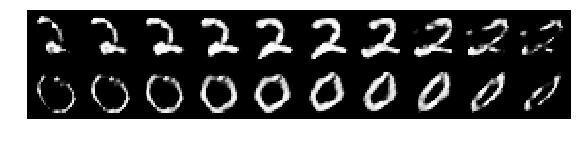

Epochs: 23.282 global_step: 20000  loss_D: 1.33678  loss_G: 0.746383  loss_Q: 0.204801 (2862.6 examples/sec; 0.022 sec/batch)


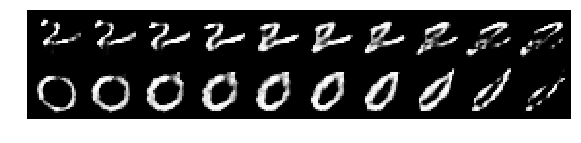

INFO:tensorflow:global_step/sec: 45.6583
Epochs: 25.610 global_step: 22000  loss_D: 1.32768  loss_G: 0.767597  loss_Q: 0.280192 (3002.6 examples/sec; 0.021 sec/batch)


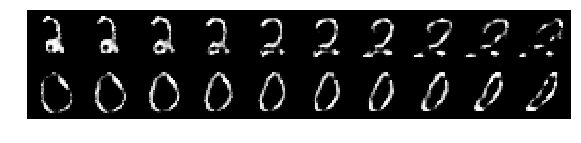

Epochs: 27.938 global_step: 24000  loss_D: 1.31273  loss_G: 0.822143  loss_Q: 0.177089 (2939.3 examples/sec; 0.022 sec/batch)


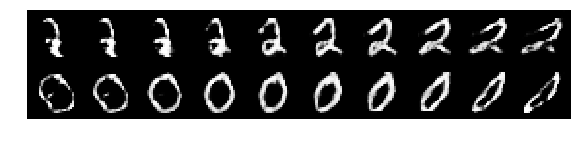

INFO:tensorflow:Saving model with global step 25771 (= 30 epochs) to disk.
Epochs: 30.266 global_step: 26000  loss_D: 1.34587  loss_G: 0.742616  loss_Q: 0.191572 (2997.4 examples/sec; 0.021 sec/batch)


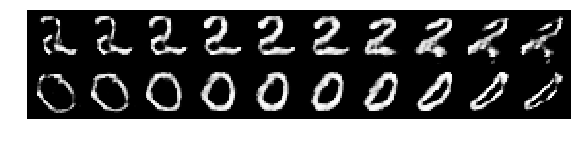

INFO:tensorflow:global_step/sec: 45.8
Epochs: 32.595 global_step: 28000  loss_D: 1.2943  loss_G: 0.782578  loss_Q: 0.179577 (2913.2 examples/sec; 0.022 sec/batch)


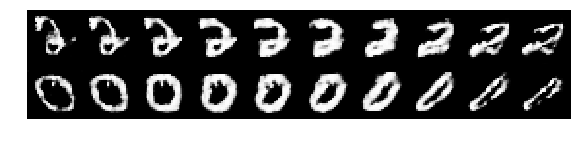

Epochs: 34.923 global_step: 30000  loss_D: 1.34954  loss_G: 0.800722  loss_Q: 0.178645 (2982.7 examples/sec; 0.021 sec/batch)


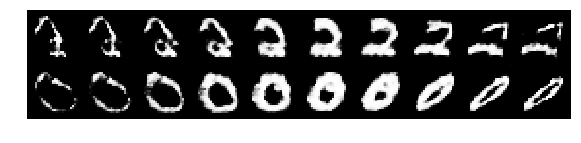

Epochs: 37.251 global_step: 32000  loss_D: 1.36359  loss_G: 0.739765  loss_Q: 0.205445 (2867.3 examples/sec; 0.022 sec/batch)


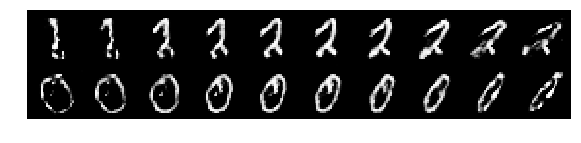

INFO:tensorflow:global_step/sec: 46.0916
Epochs: 39.579 global_step: 34000  loss_D: 1.32831  loss_G: 0.759888  loss_Q: 0.200348 (3048.5 examples/sec; 0.021 sec/batch)


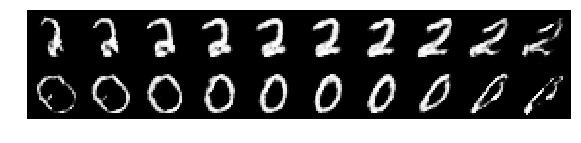

INFO:tensorflow:Saving model with global step 34361 (= 40 epochs) to disk.
Epochs: 41.908 global_step: 36000  loss_D: 1.31787  loss_G: 0.816457  loss_Q: 0.177748 (2975.4 examples/sec; 0.022 sec/batch)


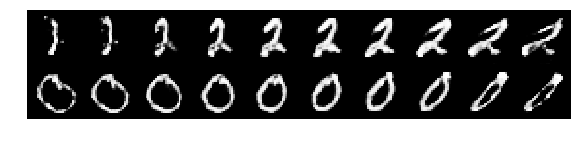

INFO:tensorflow:global_step/sec: 46.0168
Epochs: 44.236 global_step: 38000  loss_D: 1.33663  loss_G: 0.748775  loss_Q: 0.147318 (2909.6 examples/sec; 0.022 sec/batch)


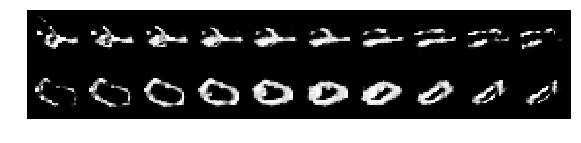

Epochs: 46.564 global_step: 40000  loss_D: 1.28527  loss_G: 0.783004  loss_Q: 0.154641 (3086.1 examples/sec; 0.021 sec/batch)


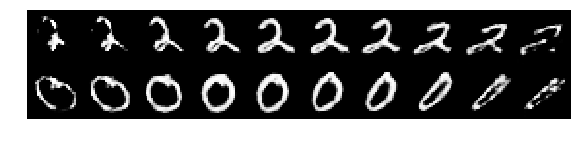

Epochs: 48.893 global_step: 42000  loss_D: 1.2491  loss_G: 0.827474  loss_Q: 0.198721 (3082.3 examples/sec; 0.021 sec/batch)


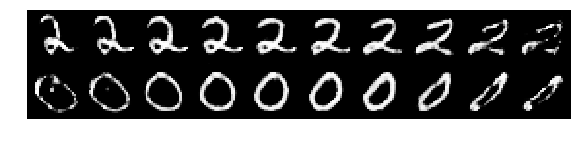

INFO:tensorflow:Saving model with global step 42951 (= 50 epochs) to disk.
INFO:tensorflow:global_step/sec: 45.875
Epochs: 51.221 global_step: 44000  loss_D: 1.38127  loss_G: 0.69371  loss_Q: 0.166538 (2973.3 examples/sec; 0.022 sec/batch)


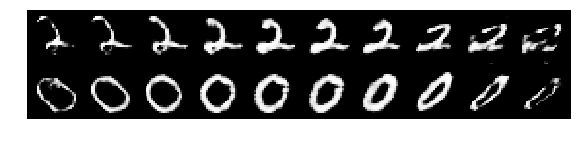

Epochs: 53.549 global_step: 46000  loss_D: 1.25187  loss_G: 0.847507  loss_Q: 0.183899 (2933.4 examples/sec; 0.022 sec/batch)


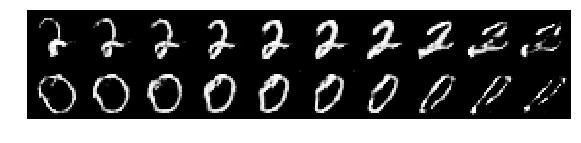

Epochs: 55.877 global_step: 48000  loss_D: 1.31283  loss_G: 0.83245  loss_Q: 0.175525 (3051.4 examples/sec; 0.021 sec/batch)


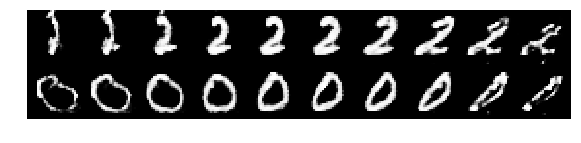

INFO:tensorflow:global_step/sec: 46.3167
Epochs: 58.206 global_step: 50000  loss_D: 1.26016  loss_G: 0.884878  loss_Q: 0.19975 (3051.4 examples/sec; 0.021 sec/batch)


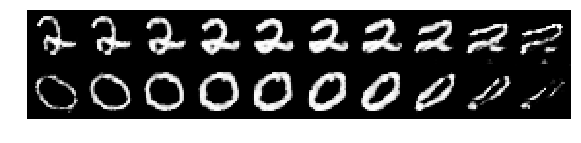

INFO:tensorflow:Saving model with global step 51541 (= 60 epochs) to disk.
Epochs: 60.534 global_step: 52000  loss_D: 1.24762  loss_G: 0.841453  loss_Q: 0.177013 (3044.2 examples/sec; 0.021 sec/batch)


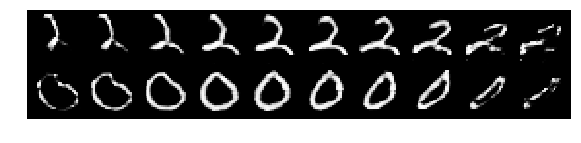

Epochs: 62.862 global_step: 54000  loss_D: 1.24237  loss_G: 0.813392  loss_Q: 0.178763 (3038.7 examples/sec; 0.021 sec/batch)


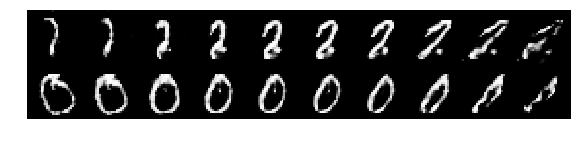

Epochs: 65.191 global_step: 56000  loss_D: 1.21353  loss_G: 0.840346  loss_Q: 0.159822 (2993.5 examples/sec; 0.021 sec/batch)


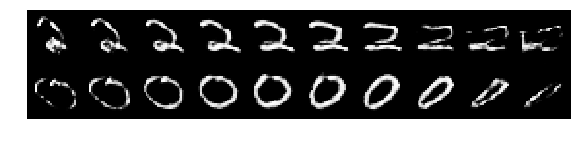

Epochs: 67.519 global_step: 58000  loss_D: 1.28546  loss_G: 0.83397  loss_Q: 0.182069 (3042.5 examples/sec; 0.021 sec/batch)


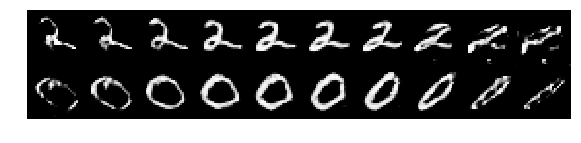

Epochs: 69.847 global_step: 60000  loss_D: 1.28407  loss_G: 0.833047  loss_Q: 0.215366 (3014.1 examples/sec; 0.021 sec/batch)


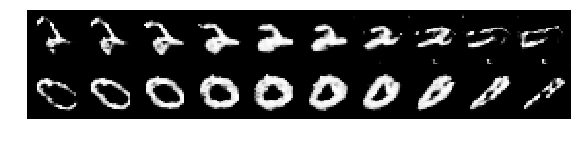

INFO:tensorflow:Saving model with global step 60131 (= 70 epochs) to disk.
Epochs: 72.176 global_step: 62000  loss_D: 1.23643  loss_G: 0.859596  loss_Q: 0.156304 (3035.4 examples/sec; 0.021 sec/batch)


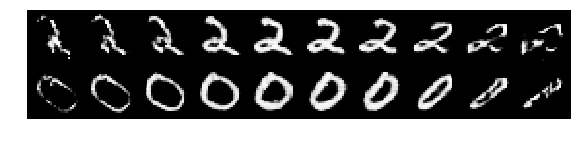

Epochs: 74.504 global_step: 64000  loss_D: 1.171  loss_G: 0.940531  loss_Q: 0.136347 (3017.5 examples/sec; 0.021 sec/batch)


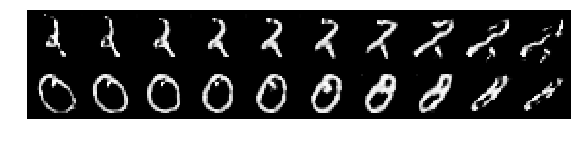

Epochs: 76.832 global_step: 66000  loss_D: 1.20977  loss_G: 0.876151  loss_Q: 0.182876 (2957.0 examples/sec; 0.022 sec/batch)


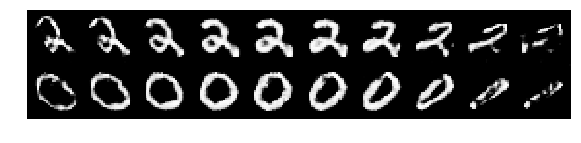

Epochs: 79.161 global_step: 68000  loss_D: 1.19527  loss_G: 0.86964  loss_Q: 0.209766 (2826.5 examples/sec; 0.023 sec/batch)


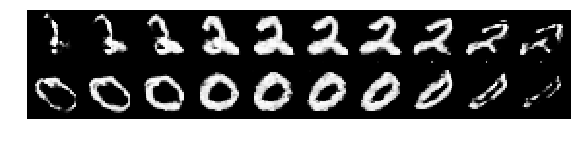

INFO:tensorflow:Saving model with global step 68721 (= 80 epochs) to disk.
Epochs: 81.489 global_step: 70000  loss_D: 1.21015  loss_G: 0.917113  loss_Q: 0.159051 (3088.7 examples/sec; 0.021 sec/batch)


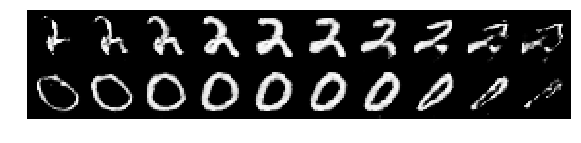

Epochs: 83.817 global_step: 72000  loss_D: 1.20419  loss_G: 0.910032  loss_Q: 0.1738 (3020.6 examples/sec; 0.021 sec/batch)


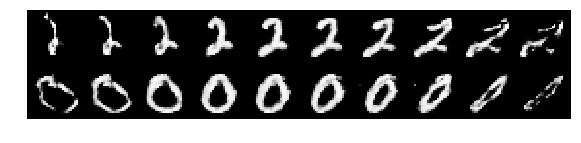

Epochs: 86.145 global_step: 74000  loss_D: 1.26258  loss_G: 0.99281  loss_Q: 0.176711 (3015.8 examples/sec; 0.021 sec/batch)


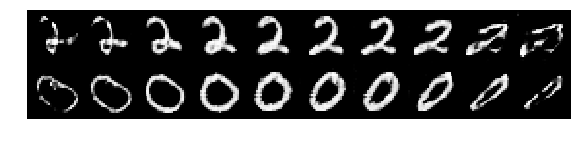

Epochs: 88.474 global_step: 76000  loss_D: 1.1907  loss_G: 0.878867  loss_Q: 0.149607 (2981.8 examples/sec; 0.021 sec/batch)


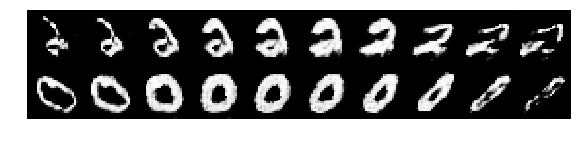

INFO:tensorflow:Saving model with global step 77311 (= 90 epochs) to disk.
Epochs: 90.802 global_step: 78000  loss_D: 1.1948  loss_G: 0.889661  loss_Q: 0.178304 (3006.5 examples/sec; 0.021 sec/batch)


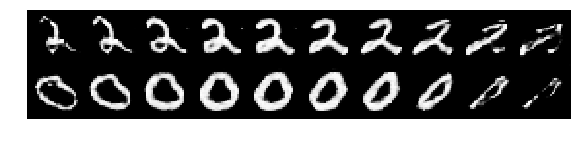

Epochs: 93.130 global_step: 80000  loss_D: 1.17585  loss_G: 0.921129  loss_Q: 0.176351 (2977.7 examples/sec; 0.021 sec/batch)


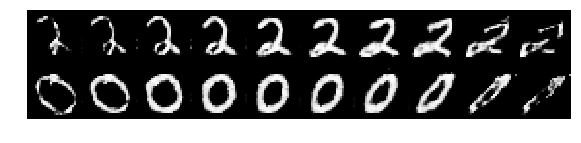

Epochs: 95.458 global_step: 82000  loss_D: 1.26556  loss_G: 0.927176  loss_Q: 0.157508 (2965.2 examples/sec; 0.022 sec/batch)


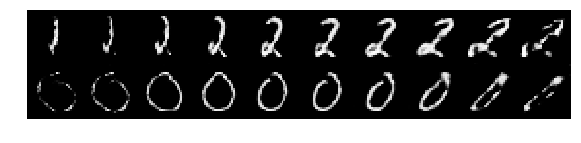

Epochs: 97.787 global_step: 84000  loss_D: 1.19997  loss_G: 0.912644  loss_Q: 0.181155 (3015.5 examples/sec; 0.021 sec/batch)


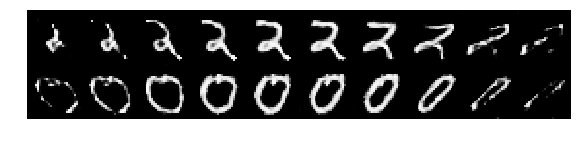

INFO:tensorflow:Saving model with global step 85901 (= 100 epochs) to disk.
INFO:tensorflow:complete training...


In [10]:
sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
with sv.managed_session(config=sess_config) as sess:
  tf.logging.info('Start Session.')
  
  #sv.start_queue_runners(sess=sess)
  #tf.logging.info('Starting Queues.')

  num_batches_per_epoch = num_examples / FLAGS.batch_size
  
  # save loss values for plot
  losses = []
  for epoch in range(FLAGS.max_epochs+1):
    for j in range(int(num_batches_per_epoch)):
      start_time = time.time()
      if sv.should_stop():
        break

      for _ in range(FLAGS.k):
        mnist_batch = mnist.train.next_batch(FLAGS.batch_size)
        random_z = np.random.uniform(low=-1., high=1., size=[FLAGS.batch_size, model.z_dim])
        categorical_code = np.random.multinomial(1,
                                                 model.categorical_code_dim * [1. / model.categorical_code_dim], 
                                                 size=[model.batch_size])
        continuous_code = np.random.uniform(low=-1., high=1., size=[FLAGS.batch_size, model.continuous_code_dim])

        _, loss_D = sess.run([opt_D_op, model.loss_Discriminator],
                              feed_dict={model.mnist: mnist_batch[0],
                                         model.random_z: random_z,
                                         model.categorical_code: categorical_code,
                                         #model.categorical_code: mnist_batch[1],
                                         model.continuous_code: continuous_code})
      _, _, _global_step,\
        loss_G, loss_Q = sess.run([opt_G_op, opt_Q_op,
                                   sv.global_step,
                                   model.loss_Generator,
                                   model.loss_Q],
                                  feed_dict={model.mnist: mnist_batch[0],
                                             model.random_z: random_z,
                                             model.categorical_code: categorical_code,
                                             #model.categorical_code: mnist_batch[1],
                                             model.continuous_code: continuous_code})

      epochs = epoch + j / num_batches_per_epoch
      duration = time.time() - start_time


      if _global_step % FLAGS.print_steps == 0:
        examples_per_sec = FLAGS.batch_size / float(duration)
        print("Epochs: %.3f global_step: %d  loss_D: %g  loss_G: %g  loss_Q: %g (%.1f examples/sec; %.3f sec/batch)"
                % (epochs, _global_step, loss_D, loss_G, loss_Q, examples_per_sec, duration))

        losses.append([epochs, loss_D, loss_G, loss_Q])

        # print sample data
        #sample_random_z = np.random.uniform(low=-1., high=1., size=[FLAGS.num_samples, model.z_dim])
        r = np.random.uniform(low=-1., high=1., size=[model.z_dim])
        sample_random_z = np.vstack([r] * FLAGS.num_samples)

        sample_categorical_code = np.zeros([FLAGS.num_samples, model.categorical_code_dim])
        sample_number = 3 # 0 ~ 9, actually arbitrary number
        sample_categorical_code[:, sample_number] = 1.

        c1 = np.linspace(-2., 2., num=FLAGS.num_samples).reshape(FLAGS.num_samples, 1)
        c2 = np.zeros([FLAGS.num_samples, 1])
        sample_continuous_code = np.concatenate((c1, c2), axis=1)
        #sample_continuous_code = np.random.uniform(low=-1., high=1., size=[FLAGS.num_samples, model.continuous_code_dim])

        sample_data1 = sess.run(model.sample_data, feed_dict={model.random_z: sample_random_z,
                                                              model.categorical_code: sample_categorical_code,
                                                              model.continuous_code: sample_continuous_code})

        sample_categorical_code = np.zeros([FLAGS.num_samples, model.categorical_code_dim])
        sample_number = 7 # 0 ~ 9, actually arbitrary number
        sample_categorical_code[:, sample_number] = 1.

        sample_continuous_code = np.concatenate((c2, c1), axis=1)
        sample_data2 = sess.run(model.sample_data, feed_dict={model.random_z: sample_random_z,
                                                              model.categorical_code: sample_categorical_code,
                                                              model.continuous_code: sample_continuous_code})
        print_sample_data(sample_data1, sample_data2)


      # write summaries periodically
      if _global_step % FLAGS.summary_steps == 0:
        summary_str = sess.run(summary_op, feed_dict={model.mnist: mnist_batch[0],
                                                      model.random_z: random_z,
                                                      model.categorical_code: categorical_code,
                                                      #model.categorical_code: mnist_batch[1],
                                                      model.continuous_code: continuous_code})
        sv.summary_computed(sess, summary_str)

      # save model checkpoint periodically
      if epoch != 0  and  epoch % FLAGS.save_epochs == 0  and  j == 0:
        tf.logging.info('Saving model with global step %d (= %d epochs) to disk.' % (_global_step, epoch))
        sv.saver.save(sess, sv.save_path, global_step=sv.global_step)
      if epoch == FLAGS.max_epochs:
        break
      
  tf.logging.info('complete training...')

## Plot loss functions

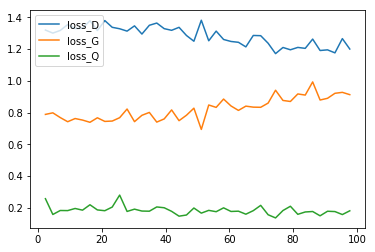

In [11]:
losses = np.asarray(losses)

plt.plot(losses[:,0], losses[:,1], label='loss_D')
plt.plot(losses[:,0], losses[:,2], label='loss_G')
plt.plot(losses[:,0], losses[:,3], label='loss_Q')
plt.legend(loc='upper left')
plt.show()